# ChBE 6745 Course Project - Visualization
Date : 04-17-2020

**Group 8**

*Group members: Aaron Liu, Brian Khau, Max Bukhovko, Nicole (Yuge) Hu, Rahul Venkatesh*

## Background
### Context
PET and many polyesters are susceptible to thermo-oxidative decomposition, especially when exposed to high temperatures. As this degradation causes a significant drop in mechanical properties, additives are typically blended into the polymer to enhance thermal stability. Thus, a contemporary problem is the **discovery of small-molecule additives** that can adequately improve the mechanical property persistence of polymer fibers after thermal exposure.

To quantify "stability", we will be using a metric known as **tenacity persistence** as our response variable $y$. This quantity is defined as:

\begin{align*}
  y = \frac{\text{tenacity after treatment}}{\text{tenacity before treatment}} (100\%)
\end{align*}

Tenacity is a measure of a fiber's ultimate breaking strength; the higher the tenacity, the more resistant the fiber is against breaking. In this case study, the samples were held in a water vessel and placed in a heater at 120$^\circ$C for 3 days. 

### Objective
The main objective of this project is to use a database of small-molecule additives and their calculated molecular descriptors to predict the tenacity persistence for polyethylene terephthlate (PET) fibers after heat exposure. This construct is also known as a quantitative structure-activity relationship (QSAR) model. **Because we are attempting to quantify a continuous variable, we will be using a QSAR regression model.**



### Dataset Details
* The data outlined in the Excel file `PETadditives_database_and_descriptors.csv` has previously been mined from patent US 3,491,057. This patent describes multiple nitrogen-containing additives added to PET fibers to improve their thermo-oxidative stability.  
* The response variable $y$ refers to the experimentally measured tenacity persistence for PET fibers augmented with a given additive. Note that $y$ has been measured in several different ways, such as in dry conditions after 1 hour, or wet conditions after 15 hours. 
* The features ($x_0$, $x_1$, $x_2$...)are molecular descriptors derived from the structure of the additive. These include descriptors such as molecular weight and branching, and were previously calculated using alvaDesc 1.0.12. Our dataset consists of 42 observations with 1862 molecular desciptors. For a complete list on the molecular descriptors, refer to this link: https://www.alvascience.com/alvadesc-descriptors/

## Baseline Model 

### Summary
In our baseline model, we performed a simple principle component regression (PCR), where we applied the following steps.
1. Scale the entire dataset. (Standard scaling)
2. Split the dataset into training and validation datasets using `train_test_split` with a hold out percentage of 20%. 
3. Naive implementation of PCA on all feature space to identify high variance principal components. 
4. Perform dimensionality reduction by using an arbitrary heuristic of retaining principal components which total to 90% of cumulative variance. 
5. Develop a linear regression model based on this subset of principal components. 
6. Assess the fitting of the given model on validation data.

### Major fallacies with our baseline model
Notably, our baseline model exhibits 3 major fallacies:
1. Scaling the entire dataset. This contaminates the validation data set because the mean and variance used to calculate the model should only be based on the training dataset.
2. Naive implementation of PCA results in loss in performance compared to the SciKit-Learn implementation.
3. Use of a threshold heuristic. This fixes the number of principal components used and provides no control to optimize the model.

## Improved Methodology
We have improved our modeling pipeline to account for these fallacies.
1. **Improved speed, efficiency, and clarity.** We use the `Pipeline()` class to wrap together all our transforms and estimators, including scaling. In addition, we will use built-in functions whenever possible (such as `PCA()`).

2. **Cross-validation/resampling accuracy estimates.**  We implement `LeaveOneOut()` or `KFold()` implicitly through `GridSearchCV()` to aid in hyperparameter tuning. This enables us to select appropriate hyperparameters, such as the number of principal components or regularization strength.

3. **More generalized regression models.** `LinearRegression()` works best when the underlying model exhibits linear correlations. Because this assumption may not hold (as with use of discrete variables or nonlinear trends), we have also looked models that perform feature selection (`LASSO()`) and dimensionality reduction(`PCA()`, `PLS()`). We will try a nonlinear PCA like kernel PCA in a future iteration of this model.

## Report accomplishments
Refer to the below figure for a visual explanation of our pipeline. In this report, we have compared the performance of the following pipelines using `LeaveOneOut()` cross-validation from `GridSearchCV()`.

### Pipeline Description
Model from previous report:
* Streamlined Baseline Model: Principal Component Regression (PCR).
    * pipeline = `StandardScaler()`, `PCA()`, `LinearRegression()`

Linear models:
* Naive model: Ordinary Least Squares (OLS).
    * pipeline = `StandardScaler()`, `LinearRegression()`
* Improved Model 1: L1-regularized least-squares (LASSO).
    * pipeline = `StandardScaler()`, `Lasso()`
* Improved Model 2: Partial-least squares regression (PLSR).
    * pipeline= `StandardScaler()`, `PLSRegression()`

Advanced models:
* Improved Model 3: Neural networks.
    * This is accomplished using code other than a pipeline; refer to the end of the document for more details on results and implementation.

### Summary of (Linear) Model Results

Note that while the summary for the linear models are here, the artificial neural network was tested on numerous different test-validation splits at the end of the document.

Using `np.random.seed(0)`:

|        | Hyperparameter | Training R2 | Validation R2 | Training RMSE | Validation RMSE |
|--------|----------------|-------------|---------------|---------------|-----------------|
| OLS    |                | 1.0000      | -4.4251       | 0.0000        | 3.8539          |
| PCR    | 19 components  | 0.8350      | -2.0211       | 1.1167        | 2.8759          |
| LASSO  | alpha=0.316    | 0.8554      | -2.2197       | 1.0455        | 2.9690          |
| PLSR   | 4 components   | 1.0000      | -4.4249       | 0.0112        | 3.8539          |

Using `np.random.seed(10)`:

|       | Hyperparameter| Training R2 | Validation R2 | Training RMSE | Validation RMSE |
|-------|---------------|-------------|---------------|---------------|-----------------|
| OLS   |               | 1.0000      | -1.0536       | 0.0000        | 2.8496          |
| PCR   | 10 components | 0.5320      | -0.1913       | 1.8608        | 2.1704          |
| LASSO | alpha = 0.316 | 0.8235      | -4.9698       | 1.1428        | 4.8586          |
| PLSR  | 4 components  | 0.7931      | -1.0244       | 1.2371        | 2.8293          |

Using `np.random.seed(40)` (as a "lucky" seed):

|       | Hyperparameter | Training R2 | Validation R2 | Training RMSE | Validation RMSE |
|-------|----------------|-------------|---------------|---------------|-----------------|
| OLS   |                | 1.0000      | 0.1603        | 0.0000        | 2.3059          | 
| PCR   | 10 components  | 0.5096      | 0.2350        | 1.8195        | 2.2009          |
| LASSO | alpha=0.233    | 0.8673      | 0.0678        | 0.9465        | 2.4295          |
| PLSR  | 4 components   | 0.7389      | 0.2827        | 1.3276        | 2.1311          |

## Import Data and Read into pandas

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns

df = pd.read_csv('PETadditives_database_and_descriptors.csv',index_col="No.")
df.head(3) # First 5 columns

,NAME,Addition Method,Amount Added,dry 1 hr,dry 2 hr,dry 3 hr,wet 3 day,wet 5 day,wet 15 day,MW,...,BLTA96,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_cons,LLS_01,LLS_02
No.,,,,,,,,,,,,,,,,,,,,,
1,CC1=CC=CC=C1N=C=NC2=CC=CC=C2C,A,0.25,68.5,59.0,50.7,18.8,0.0,0.0,222.31,...,-5.190376,1.0,1.000000,1.000000,0.6,0.5,1.0,0.871429,0.833333,1.0
2,O=C(N1)C2=CC=CC(CC3=CC=CC=C3)=C2C1=O,A,0.25,78.1,70.0,63.5,69.6,30.7,6.4,237.27,...,-4.354596,1.0,1.000000,1.000000,0.6,0.0,1.0,0.800000,0.833333,1.0
3,O=C(N1)C2=CC=CC(C(C)=O)=C2C1=O,A,0.25,74.3,67.6,60.1,55.1,22.4,0.0,189.18,...,-2.608074,1.0,0.833333,0.833333,0.4,0.0,1.0,0.723810,0.666667,1.0


## Filter Data

Since our dataset above contains various processing parameters, such as additive method and the amount of additive added, we additionally filtered the observations to correspond to additive method A and 0.25 as the amount added. Also note that we have multiple outputs, corresponding to tenacities measured at different conditions. **We will be using the first output, dry 1 hour.**

In [2]:
# filter and extract dry 0 hr values as y
df_filtered = df[(df['Amount Added'] == 0.25)&(df['Addition Method'] == 'A')]
df_Y = df_filtered.iloc[:,3:9]
df_Y.head(2)

,dry 1 hr,dry 2 hr,dry 3 hr,wet 3 day,wet 5 day,wet 15 day
No.,,,,,,
1,68.5,59.0,50.7,18.8,0.0,0.0
2,78.1,70.0,63.5,69.6,30.7,6.4


In [3]:
# Define X dataframe

df_X = df_filtered.iloc[:,9:]
# mask out columns where all the rows are the same value
nunique = df_X.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df_X.drop(cols_to_drop, axis=1)
df_X.head(2)

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,BLTA96,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_cons,LLS_01,LLS_02
No.,,,,,,,,,,,,,,,,,,,,,
1,222.31,7.171290,20.2036,30.5052,21.5798,34.4878,0.651729,0.984039,0.696123,1.11251,...,-5.190376,1.0,1.0,1.0,0.6,0.5,1.0,0.871429,0.833333,1.0
2,237.27,8.181724,20.0850,29.1744,20.7217,31.9931,0.692586,1.006014,0.714541,1.10321,...,-4.354596,1.0,1.0,1.0,0.6,0.0,1.0,0.800000,0.833333,1.0


## Model Helper Functions

To improve readability within this notebook, we have constructed a small set of helper functions that encapsulate visualization or pipeline tasks later on:

The `parity_plotter` code block takes in a fitted `GridSearch` object along with the testing and validation data.
* Plots the corresponding parity plot using the object's best estimator.
* Prints out the R2 and RMSE scores for the training and validation sets.

In [4]:
from sklearn.metrics import mean_squared_error

def parity_plotter(grid_search_obj, X_train, X_valid, y_train, y_valid):
    # input: gridsearch object, training and validation datasets
    # output: None
    # prints out parity plots and scores
    
    # Compute and output scores
    print("Best parameters: {}".format(grid_search_obj.best_params_))
    
    yhat_train = grid_search_obj.best_estimator_.predict(X_train)
    train_score = grid_search_obj.best_estimator_.score(X_train, y_train)
    print("Training R2 score: {}".format(train_score))
    rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
    print("Training RMSE: {}".format(rmse_train))
          
    yhat_valid = grid_search_obj.best_estimator_.predict(X_valid)
    valid_score = grid_search_obj.best_estimator_.score(X_valid, y_valid)
    print("Validation R2 score: {}".format(valid_score))
    rmse_train = np.sqrt(mean_squared_error(y_valid, yhat_valid))
    print("Validation RMSE: {}".format(rmse_train))

    # Superimpose testing and training points
    fig, ax = plt.subplots()
    ax.scatter(y_train, yhat_train, label='training')
    ax.scatter(y_valid, yhat_valid, label='validation')
    ax.plot(y_train, y_train, 'k-');
          
    ax.set_xlabel("Actual y")
    ax.set_ylabel("Predicted y")
    ax.legend()
          
    return

The `gridsearch_pipeline_fit` code block takes in `Pipeline` object for the model, a parameter grid, and the associated training and validation data. 
* Fits and returns a `GridSearch` object. 
* Prints out the best hyperparameters for the associated pipeline. 

In [5]:
from sklearn.model_selection import LeaveOneOut

def gridsearch_pipeline_fit(pipe, param_grid, X_train, X_valid, y_train, y_valid):
    # input: pipeline object, parameter grid (as dict)
    # uses leave one out cross-validation iterator with score as max_error
    # output: grid_search_obj
    
    cv = LeaveOneOut()
    search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='max_error',n_jobs=-1,cv=cv,return_train_score=True)
    search.fit(X_train, y_train) 
    
    print("Best parameter (CV test score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    
    return search

The `one_param_plotter` function takes in a fitted `GridSearch` object, the hyperparameter to plot against, and the associated testing data.
* Plots the mean training and testing errors associated with cross-validation.

In [6]:
def one_param_plotter(grid_search_obj, hyperparameter, X_train, X_test,is_log=False):
    # input: grid_search_object, hyperparameter as string
    # plots training/testing score as a function of hyperparameter (with errors) 
    # output:None
    
    if len(grid_search_obj.param_grid) != 1:
        print("cannot plot more than one hyperparameter")
        return
    
    if hyperparameter not in grid_search_obj.param_grid.keys():
        print("key does not exist in param_grid")
        return
    
    N_train = search.cv.get_n_splits(X_train)
    N_test = search.cv.get_n_splits(X_test)
    
    train_scores = grid_search_obj.cv_results_['mean_train_score']
    train_scores_stdev = grid_search_obj.cv_results_['std_train_score']/np.sqrt(N_train)

    test_scores = grid_search_obj.cv_results_['mean_test_score']
    test_scores_stdev = grid_search_obj.cv_results_['std_test_score']/np.sqrt(N_test)

    # plot error lines showing +/- std. deviation of the scores
    train_std_error = train_scores_stdev
    test_std_error = test_scores_stdev
    
    param_range = grid_search_obj.param_grid[hyperparameter]
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    
    if is_log: # linear plot
        # plot training scores   
        ax[0].semilogx(param_range, train_scores + train_std_error, 'b--')
        ax[0].semilogx(param_range, train_scores - train_std_error, 'b--')
        ax[0].semilogx(param_range, train_scores, 'ko-')
        # plot testing scores
        ax[1].semilogx(param_range, test_scores + test_std_error, 'b--')
        ax[1].semilogx(param_range, test_scores - test_std_error, 'b--')
        ax[1].semilogx(param_range, test_scores, 'ko-')  
        
    else:   # linear plot
        # plot training scores   
        ax[0].plot(param_range, train_scores + train_std_error, 'b--')
        ax[0].plot(param_range, train_scores - train_std_error, 'b--')
        ax[0].plot(param_range, train_scores, 'ko-')
        # plot testing scores
        ax[1].plot(param_range, test_scores + test_std_error, 'b--')
        ax[1].plot(param_range, test_scores - test_std_error, 'b--')
        ax[1].plot(param_range, test_scores, 'ko-')  
        
    ax[0].fill_between(param_range, 
                       train_scores + train_std_error, train_scores - train_std_error, alpha=0.2)
    ax[0].set_ylabel('Train RMSE +/- std error')
    ax[0].set_xlabel(hyperparameter)
    ax[0].axhline(np.max(train_scores), linestyle='--', color='.5')
    ax[0].set_title('Train RMSE vs {}'.format(hyperparameter))

    ax[1].fill_between(param_range, 
                       test_scores + test_std_error, test_scores - test_std_error, alpha=0.2)
    ax[1].set_ylabel('Test RMSE +/- std error')
    ax[1].set_xlabel(hyperparameter)
    ax[1].axhline(np.max(test_scores), linestyle='--', color='.5')
    ax[1].set_title('Test RMSE vs {}'.format(hyperparameter))

In [18]:
# Scale the dataframe
from sklearn.preprocessing import StandardScaler

# Make a scaled copy
df_Xs = pd.DataFrame.copy(df_X)
scaler = StandardScaler()
df_Xs[:] = scaler.fit_transform(df_Xs[:])
df_Xs.head(2)

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,BLTA96,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_cons,LLS_01,LLS_02
No.,,,,,,,,,,,,,,,,,,,,,
1,0.528132,-0.778083,0.791968,0.729429,0.846351,0.776358,0.166354,-1.469250,0.665570,-0.685788,...,-1.537739,0.27735,1.427493,1.493576,-0.14911,0.440225,0.156174,0.705557,0.226575,0.27735
2,0.780527,0.319514,0.770815,0.559916,0.705061,0.496647,0.821312,-0.441211,1.048068,-1.116209,...,-1.001569,0.27735,1.427493,1.493576,-0.14911,-0.792406,0.156174,-0.119886,0.226575,0.27735


In [19]:
def corr_matrix(df,units=100):
    #input: input DataFrame as feature matrix
    #units: plot numbers at each unit
    #output correlation matrix using viridis heatmap
    
    corr = pd.DataFrame.corr(df)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(10,7))
        sns.heatmap(corr, mask=mask ,square=True, cmap = 'coolwarm',xticklabels=units, yticklabels=units)
    return corr

We plot the correlation matrix, with labels every 100 values. Defined names for each molecular descriptor can be found at https://www.alvascience.com/alvadesc-descriptors/.

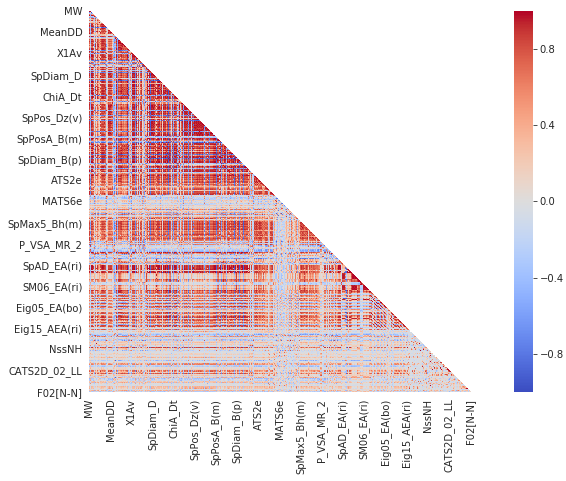

In [20]:
corr = corr_matrix(df_Xs)

We can see that there's actually quite a lot of correlated (and noncorrelated) variables on the off-diagonals of this correlation matrix. This observation suggests that many variables are not independent.

In [21]:
def corr_printer(x1, x2, df):
    print("Feature {} is {}".format(x1,df_X.columns[x1]))
    print("Feature {} is {}".format(x2,df_X.columns[x2] ))
    print("Correlation between feature {} and feature {} is {:.4f}".format(x1,x2,corr.iloc[x1,x2]))
    sns.jointplot(df_X.columns[x1], df_X.columns[x2],data=df,kind='reg')
    return

Some variables are continuous, as shown by this plot of first ionization potential vs molecular weight:

Feature 0 is MW
Feature 9 is Mi
Correlation between feature 0 and feature 9 is -0.6898


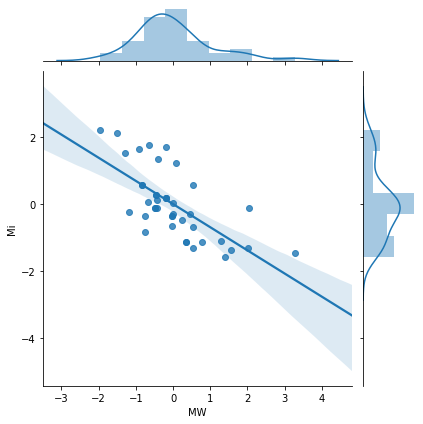

In [22]:
# Molecular weight vs first ionization potential (which should be anti-correlated)
corr_printer(0,9,df_Xs)

However, we also have numerous discrete variables (constitutional or topological indices). Here, we can also plot the number of carbons vs the number of oxygens.

Feature 23 is nC
Feature 25 is nO
Correlation between feature 23 and feature 25 is -0.1489


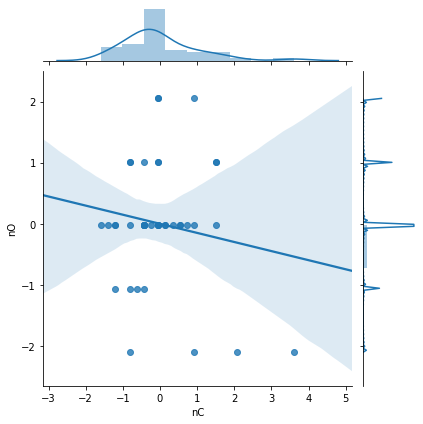

In [23]:
# Molecular weight vs first ionization potential (which should be anti-correlated)
corr_printer(23,25,df_Xs)